In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.contrib import rnn
from sklearn.preprocessing import MinMaxScaler
import time


#Preprocessing training data
data = pd.read_csv('/Users/til018/Desktop/stock_price_prediction/Google_Stock_Price_Train.csv')
#Read 'open' only
data = data.iloc[:, 1:2]
#Convert string into array
data = data.values

#Data normalization
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

#Split data
X_train = data[:-1]
y_train = data[1:]
X_train = np.reshape(X_train, (1257, 1, 1))
X = tf.placeholder(tf.float32, [None, 1, 1])
Y = tf.placeholder(tf.float32, [None, 1])

#LSTM cell
cell = tf.contrib.rnn.BasicLSTMCell(num_units=128, state_is_tuple=True, activation=tf.tanh)

outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

#Fully connected layer
y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=None)
learning_rate=0.01
loss = tf.reduce_sum(tf.square(y_pred - Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [2]:
prediction = tf.argmax(outputs, axis=2)

targets = tf.placeholder(tf.float32, [None, 1,1])
predictions = tf.placeholder(tf.float32, [None, 1])

#Compute rmse
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [3]:
#Preprocessing test data
test_csv = pd.read_csv('/Users/til018/Desktop/stock_price_prediction/Google_Stock_Price_Test.csv')
test = test_csv.iloc[:, 1:2].values

X_test = test
X_test = scaler.transform(X_test)
X_test.shape
X_test = np.reshape(X_test, (20, 1, 1))

[step: 0] loss: 396.0735168457031
[step: 100] loss: 0.4373546540737152
[step: 200] loss: 0.3627339005470276
[step: 300] loss: 0.31760576367378235
[step: 400] loss: 0.3073606789112091
[step: 500] loss: 0.3068094551563263
[step: 600] loss: 0.3067956566810608
[step: 700] loss: 0.3067888915538788
[step: 800] loss: 0.3067817986011505
[step: 900] loss: 0.3067745864391327
RMSE: 805.9627685546875
--- 46.75025796890259 seconds ---


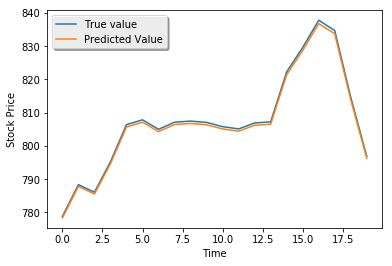

In [4]:
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        _,l = sess.run([train, loss], feed_dict={X: X_train, Y: y_train})
        if i % 100 == 0:
            print ("[step: {}] loss: {}".format(i, l))
        
    test_predict = sess.run(y_pred, feed_dict={X: X_test})

    #Inverse data back to real number for better plot result
    test_predict = scaler.inverse_transform(test_predict)

    rmse_val = sess.run(rmse, feed_dict={
                    targets: X_test, predictions: test_predict})

    print("RMSE: {}".format(rmse_val))
    print("--- %s seconds ---" % (time.time() - start_time))
    plt.plot(test, label='True value')
    plt.plot(test_predict, label='Predicted Value')
    plt.xlabel("Time")
    plt.ylabel("Stock Price")

    #Plot the graph
    legend = plt.legend(loc='upper left', shadow=True)


    plt.show()
    